In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
#importamos las librerias necesarias para el procesamiento de los datos
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc



from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

from keras_tuner import RandomSearch


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Quitar las contracciones en el idioma inglés
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    phrase = re.sub(r"u.s.", " us", phrase)
    return phrase



In [ ]:
#leemos los datos
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
#df.head(7)
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
#df_test.head()
df_submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/submit.csv')
#df_submit.head()
df=df.dropna()


In [ ]:
#Preprocesamos los datos
stemmer = PorterStemmer()
corpus= []
corpus_test=[]
iterador_titulo= iter(df['title'])
#iterador_titulo_test=iter(df_test['title'])

for titulo in iterador_titulo:
  datos= re.sub(r'[^a-zA-Z]',' ', titulo)
  datos = datos.lower().split()
  datos = [stemmer.stem(palabra) for palabra in datos if not palabra in stopwords.words('english')]
  datos = ' '.join(datos)
  corpus.append(datos)


df['cleantitle']= corpus
df.head(7)

,id,title,author,text,label,cleantitle
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,hous dem aid even see comey letter jason chaff...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillari clinton big woman campu breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,civilian kill singl us airstrik identifi
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jail fiction unpublish stori wom...
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,jacki mason hollywood would love trump bomb no...
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,beno hamon win french socialist parti presiden...


In [ ]:
#tokenizamos los datos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleantitle'])
sequences = tokenizer.texts_to_sequences(df['cleantitle'])
print(sequences)
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
#print(padded_sequences)
print(padded_sequences.shape)

In [ ]:

x_train=padded_sequences
y_train=df['label']

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

14628
3657
14628
3657


In [ ]:
#Creamos el modelo LSTM
voc_size=20000
embedding_vector_features = 40 #Feature Representation


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_size, output_dim= embedding_vector_features),
    tf.keras.layers.LSTM(10), # LSTM con 10 neuronas
    tf.keras.layers.Dense(1, activation='sigmoid')  # clasificación binaria 0 o 1
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#Entrenamos el modelo
model.fit(X_train,Y_train,validation_data=( X_test,Y_test),epochs=10)


Epoch 1/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9551 - loss: 0.1788 - val_accuracy: 0.7613 - val_loss: 0.5123
Epoch 2/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7955 - loss: 0.4616 - val_accuracy: 0.7952 - val_loss: 0.4907
Epoch 3/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8632 - loss: 0.3603 - val_accuracy: 0.8422 - val_loss: 0.4432
Epoch 4/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8972 - loss: 0.3091 - val_accuracy: 0.7312 - val_loss: 0.5079
Epoch 5/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7571 - loss: 0.4787 - val_accuracy: 0.8605 - val_loss: 0.4610
Epoch 6/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9164 - loss: 0.2946 - val_accuracy: 0.8594 - val_loss: 0.4208
Epoch 7/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9242 - loss: 0.2612 - val_accuracy: 0.8603 - val_loss: 0.4266
Epoch 8/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9267 - loss: 0.2554 - val_accuracy: 0.

In [ ]:
loss, accuracy = model.evaluate (X_test,Y_test)
print(f" Accuracy en el conjunto de test : { accuracy*100:.2f}% loss: {loss}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.4314
 Accuracy en el conjunto de test : 86.30% loss: 0.4350270628929138


In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/modelLSTM1.keras')

In [ ]:
#obtenemos las predicciones del modelo
predictions_prob = model.predict(X_test)

predictions=np.round(predictions_prob)
predictions=predictions.astype(int).flatten()
print("predictions")
print(predictions[0:3])
print(Y_test[0:3])

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
predictions
[1 0 0]
11784    1
6997     0
14903    0
Name: label, dtype: int64


In [ ]:
#Calculamos metricas
roc_auc = roc_auc_score(Y_test, predictions_prob)
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

# Print the metrics
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.81
Accuracy: 0.86
Precision: 0.90
Recall: 0.77
F1 Score: 0.83


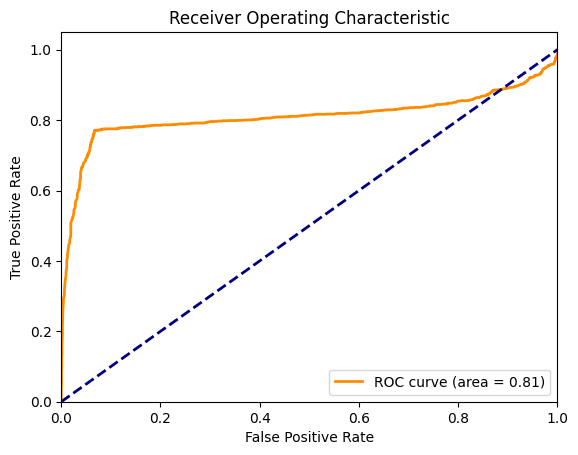

In [ ]:
#Curva TOC
fpr, tpr, thresholds = roc_curve(Y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##Síntonización de hiperparámetros

In [ ]:
# Número de épocas para los experimentos
epochs = 10
voc_size=20000
embedding_vector_features = 40

In [ ]:
#Construcción del modelo y los parametros a sintonizar
def build_model(hp):
  model = Sequential()
  model.add(Embedding(input_dim=voc_size, output_dim= embedding_vector_features))
  model.add(LSTM(units = hp.Choice('unitss1',[10,50,100,200,256] )))
  model.add(Dense(1, activation = hp.Choice('activation2', ['relu', 'sigmoid'])))
  optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.001]))
  model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
  return model

In [ ]:
#Sintonización de hiperparámetros con RandomSearch
tuner = RandomSearch(build_model, objective = 'val_loss', max_trials = 10)
tuner.search(X_train, Y_train, epochs = epochs, validation_data = (X_test, Y_test), verbose=2, callbacks=[tf.keras.callbacks.TensorBoard('my_dir')], batch_size = 128)
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 11s]
val_loss: 0.6834749579429626

Best val_loss So Far: 0.19027568399906158
Total elapsed time: 00h 01m 51s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
#Mejores valores para los hiperparámetros
print( "neurons:", best_model.layers[1].units)
print("activation: ", best_model.layers[2].activation)
print("learning rate: ", best_model.optimizer.learning_rate)

neurons: 200
activation:  <function sigmoid at 0x7bba74981300>
learning rate:  <Variable path=adam/learning_rate, shape=(), dtype=float32, value=0.009999999776482582>


In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, Y_test)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.2043
test_acc: 0.9152310490608215
test_loss: 0.19027625024318695


In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/modelLSTMBestModel.keras')


In [ ]:
predictions_best_prob = best_model.predict(X_test)

predictions_best=np.round(predictions_best_prob)
predictions_best=predictions_best.astype(int).flatten()
print("predictions")
print(predictions_best[0:3])
print(Y_test[0:3])

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
predictions
[1 0 0]
11784    1
6997     0
14903    0
Name: label, dtype: int64


In [ ]:
#Calculamos métricas para el mejor modelo
roc_auc = roc_auc_score(Y_test, predictions_best_prob)
accuracy = accuracy_score(Y_test, predictions_best)
precision = precision_score(Y_test, predictions_best)
recall = recall_score(Y_test, predictions_best)
f1 = f1_score(Y_test, predictions_best)

# Print the metrics
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.98
Accuracy: 0.92
Precision: 0.90
Recall: 0.91
F1 Score: 0.90


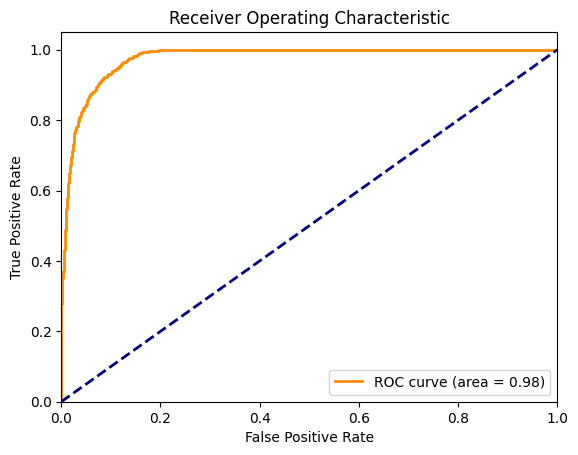

In [ ]:
#Curva Roc
fpr, tpr, thresholds = roc_curve(Y_test, predictions_best_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()